<h3>ANN for classification - Example 1 - Mobile price classifier</h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

<b>Load the data</b>

In [2]:
df = pd.read_csv("mobilepricerangeclass.csv")
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [3]:
# quick basic check, do we have duplicate rows
# duplicate rows usually are just noise
df.duplicated().sum()

0

In [4]:
# common quick check, do we have missing values, and if so
# in which variables
df.isna().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

<b>Let's compare the variables, can we drop something?</b>

In [5]:
# remember: any variable that doesn't bring anything to the table
# is essentially just noise for the machine learning model

corr_matrix = df.corr()['price_range']
corr_matrix.sort_values(ascending=False)

price_range      1.000000
ram              0.917046
battery_power    0.200723
px_width         0.165818
px_height        0.148858
int_memory       0.044435
sc_w             0.038711
pc               0.033599
three_g          0.023611
sc_h             0.022986
fc               0.021998
talk_time        0.021859
blue             0.020573
wifi             0.018785
dual_sim         0.017444
four_g           0.014772
n_cores          0.004399
m_dep            0.000853
clock_speed     -0.006606
mobile_wt       -0.030302
touch_screen    -0.030411
Name: price_range, dtype: float64

<b>First version: Without any optimizations, let's try a classification model</b>

In [6]:
# 
df['price_range'] = df['price_range'].replace({0: "1: Cheap", 1: "2: Avg-", 2: "3: Avg+", 3: "4: Expensive"})

In [7]:
# by inspecting correlation matrix and SelectKBest results
# we decided to drop these variables, since they don't really bring anything into the result
# thus resulting in extra noise in the dataset
removables = ["dual_sim", "touch_screen", "clock_speed", "m_dep", "three_g", "four_g", "wifi", "blue"]
df = df.drop(removables, axis=1)

In [8]:
df.head()

,battery_power,fc,int_memory,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,price_range
0,842,1,7,188,2,2,20,756,2549,9,7,19,2: Avg-
1,1021,0,53,136,3,6,905,1988,2631,17,3,7,3: Avg+
2,563,2,41,145,5,6,1263,1716,2603,11,2,9,3: Avg+
3,615,0,10,131,6,9,1216,1786,2769,16,8,11,3: Avg+
4,1821,13,44,141,2,14,1208,1212,1411,8,2,15,2: Avg-


In [9]:
# save the categories into a list
categories = list(np.unique(df['price_range']))
print(categories)

['1: Cheap', '2: Avg-', '3: Avg+', '4: Expensive']


<b>X/y train/test/validation -split</b>

In [10]:
# everything else except the target variable
X = df.drop("price_range", axis=1)

# have only the target variable here (dependent variable)
y_temp = df['price_range']

# since we are doing classification, we have to process our target values with an encoder
# and convert them into a categorical TensorFlow/Keras -format 
le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

# Converting the label into a matrix form
y = tf.keras.utils.to_categorical(y_enc)

In [11]:
y

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on price
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
8,ram,931267.52
6,px_height,17363.57
0,battery_power,14129.87
7,px_width,9810.59
3,mobile_wt,95.97
2,int_memory,89.84
10,sc_w,16.48
11,talk_time,13.24
1,fc,10.14
9,sc_h,9.61


In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

<b>Create neural network model</b>

In [14]:
# we optimized very lightly, by adding normalization and regularization
# seems to work quite well with 96%~ accuracy
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dense(8, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\janni\OneDrive\DeepLAdDA\.venv\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428 (1.67 KB)

 Trainable params: 404 (1.58 KB)

 Non-trainable params: 24 (96.00 B)

In [15]:
# adjust epochs as you see fit
model.fit(x=X_train, y=y_train, epochs=500, validation_data=(X_val, y_val))

Epoch 1/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2590 - loss: 5.7839 - val_accuracy: 0.2433 - val_loss: 5.8784
Epoch 2/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2840 - loss: 4.9240 - val_accuracy: 0.2733 - val_loss: 4.5207
Epoch 3/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3402 - loss: 4.1899 - val_accuracy: 0.3000 - val_loss: 3.7682
Epoch 4/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3801 - loss: 3.5645 - val_accuracy: 0.3500 - val_loss: 3.1607
Epoch 5/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3942 - loss: 3.0132 - val_accuracy: 0.4367 - val_loss: 2.6578
Epoch 6/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4774 - loss: 2.5332 - val_accuracy: 0.5067 - val_loss: 2.1976
Epoch 7/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4986 - loss: 2.0875 - val_accuracy: 0.5333 - val_loss: 1.7898
Epoch 8/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5583 - loss: 1.6903 - val_accuracy: 0.5267 - 

<Axes: >

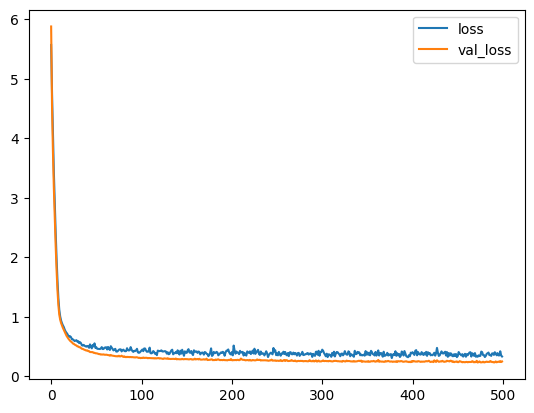

In [16]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

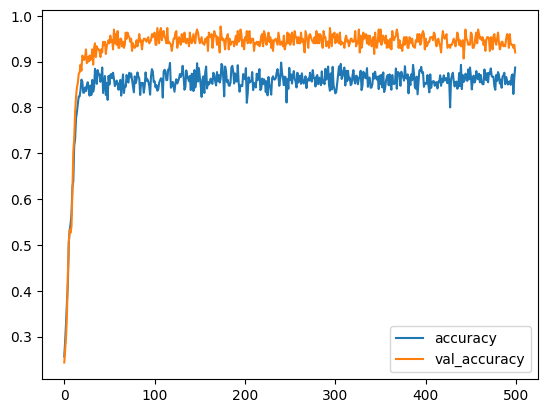

In [17]:
loss_df[['accuracy', 'val_accuracy']].plot()

In [18]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.2375044822692871, 0.9233333468437195]

Train data evaluation:
[0.21985027194023132, 0.9435714483261108]


In [19]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


<Axes: >

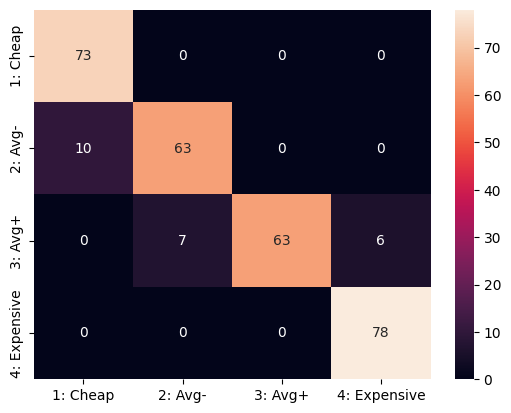

In [20]:
# confusion matrix
sns.heatmap(confusion_matrix(y_test, test_predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt='g')

In [21]:
# print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions, target_names=categories))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

    1: Cheap       0.88      1.00      0.94        73
     2: Avg-       0.90      0.86      0.88        73
     3: Avg+       1.00      0.83      0.91        76
4: Expensive       0.93      1.00      0.96        78

    accuracy                           0.92       300
   macro avg       0.93      0.92      0.92       300
weighted avg       0.93      0.92      0.92       300


Model overall accuracy: 92.33%


In [22]:
# In multi category classification , AUC values are often interpreted as follows: 
# 0.5-0.6 (failed)
# 0.6-0.7 (worthless)
# 0.7-0.8 (poor)
# 0.8-0.9 (good)
# > 0.9 (excellent)

# get ROC-AUC -score
roc_auc_score(y, model.predict(X), multi_class="ovr")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


0.9977053333333333

In [23]:
df.columns

Index(['battery_power', 'fc', 'int_memory', 'mobile_wt', 'n_cores', 'pc',
       'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time',
       'price_range'],
      dtype='object')

In [24]:
# let's try with some new imaginary data
# modify this as needed regarding your own dataset
tester_row = {
    'battery_power': 800, 
    'fc': 12, 
    'int_memory': 2,  
    'mobile_wt': 300, 
    'n_cores': 4, 
    'pc': 36,
    'px_width': 1890,
    'px_height': 1222, 
    'ram': 8096,
    'sc_h': 13, 
    'sc_w': 4, 
    'talk_time': 19
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])
result = model.predict(tester_row)[0]
result_text = categories[np.argmax(result)]

# 0 cheapest, 3 most expensive
print("-> 0 cheapest, 3 most expensive category")
print(f"Predicted price range: {result_text}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
-> 0 cheapest, 3 most expensive category
Predicted price range: 4: Expensive


<b>Save the model to a file so that we can use it in our GUI applications</b>

In [25]:
model.save("mobilephonemodel.keras")